Not getting Me for LT2p. Analyze where the T is going.
Claim that Tp/T relates to Yp/Y.
Analyze states of T: by p, by Me, by L. Show evolution of fractions over time.

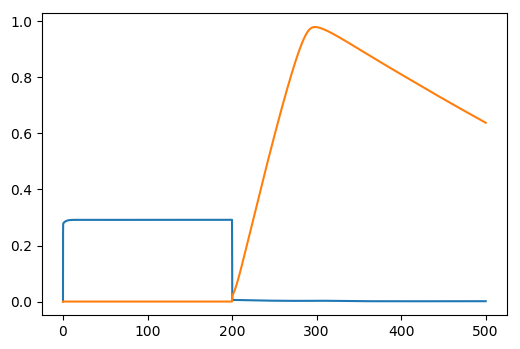

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from chemotaxis_model import ChemotaxisModel

model = ChemotaxisModel()
model.appendToModel('''at (time > 200): L = 0.11e-3''')
#model.appendToModel('''at (time > 100): k0 = 0.088e-6''')
#model.appendToModel('''at (time > 200): k0 = 0, L=3e-6''')

model.initialize()
result = model.run()
time = result['time']
ypfrc = model.getYpFraction()
states = model.getReceptorStates()
total = states.sumStates(lambda l,p,m: True)
frLT = states.sumStates(lambda l,p,m: l)/total
frLTp = states.sumStates(lambda l,p,m: l and p)/total
plt.plot(time, ypfrc, time, frLTp)
#rr.plot(result, xlim=[0, end_time])

In [2]:
lt

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
         4.91580017e-06,   4.91451714e-06,   4.91323421e-06])

Expected to see an impulse response in response to the step input. But see a step response in Yp.

In [ ]:
Ids = ['J11', 'J12', 'J3']
{id: model.getReactionRateForId(id) for id in Ids}